In [1]:
import cupy as cp
from PIL import Image
import torchvision.transforms.functional as TF

In [2]:
# 将 JPG 图像转换为数组
pic = Image.open('./超级无敌大开门.jpg')
pic = TF.to_tensor(pic)
pic_ = cp.array(pic)
# 将样本 X 展开
X = pic_.reshape(1, -1)
icput_size = X.shape[1]
X

array([[0.48235294, 0.47843137, 0.4745098 , ..., 0.5372549 , 0.5372549 ,
        0.5372549 ]], shape=(1, 331776), dtype=float32)

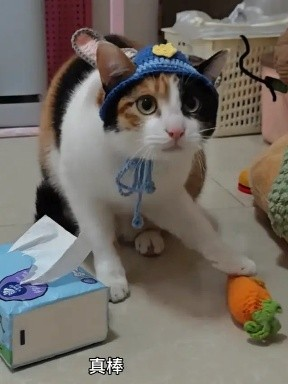

In [3]:
import torchvision.transforms as transforms
# 将张量还原为图片
transforms.ToPILImage()(pic)

In [4]:
class VAE:

    """
    VAE 自编码器
    """

    def __init__(
            self,
            icput_size: cp.ndarray = None,
            hidden_size: cp.ndarray = None
    ):
        
        """
        初始化 VAE 网络的权重矩阵和偏置向量

        Paramters
        ---------
        icput_size : 输入维度
        hidden_size : 隐状态维度
        """
        
        self.hidden_size = hidden_size
        self.icput_size = icput_size

        # 编码器网络的权重矩阵和偏置向量
        self.W_mu_q = cp.zeros((hidden_size, icput_size))
        self.b_mu_q = cp.zeros(hidden_size)
        self.W_lnsigma_q = cp.zeros((hidden_size, icput_size))
        self.b_lnsigma_q = cp.zeros(hidden_size)

        # 解码器网络的权重矩阵和偏置向量
        self.W_mu_d = cp.zeros((icput_size, hidden_size))
        self.b_mu_d = cp.zeros(icput_size)
        self.W_lnsigma_d = cp.zeros((icput_size, hidden_size))
        self.b_lnsigma_d = cp.zeros(icput_size)

    def Encoder(self, x: cp.ndarray = None) -> tuple[cp.ndarray, cp.ndarray]:

        """
        编码器，学习隐状态 z 的变分分布

        Parameters
        ----------
        x : 特征数据集

        Returns
        -------
        mu_q : 隐状态 z 的均值向量
        lnsigma_q : 隐状态 z 的对数方差向量
        """

        x = cp.expand_dims(x, axis = 2)
        mu_q = (self.W_mu_q @ x).squeeze(2) + self.b_mu_q
        lnsigma_q = (self.W_lnsigma_q @ x).squeeze(-1) + self.b_lnsigma_q

        return mu_q, lnsigma_q
    
    def Decoder(self, z: cp.ndarray = None) -> tuple[cp.ndarray, cp.ndarray]:

        """
        解码器，学习样本 x 的后验分布

        Parameters
        ----------
        z : 隐状态

        Returns
        -------
        mu_d : 生成样本 x 的均值向量
        lnsigma_d : 生成样本 x 的对数方差向量
        """

        z = cp.expand_dims(z, axis = -1)
        mu_d = (self.W_mu_d @ z).squeeze(-1) + self.b_mu_d
        lnsigma_d = (self.W_lnsigma_d @ z).squeeze(-1) + self.b_lnsigma_d

        return mu_d, lnsigma_d
    
    def forward(self, x: cp.ndarray = None) -> tuple[cp.ndarray, cp.ndarray, cp.ndarray, cp.ndarray]:

        """
        前向传播，输出隐状态 z 的均值和对数方差向量，生成样本 x 的均值和对数方差向量
        
        Parameters
        ----------
        x : 特征数据集

        Returns
        -------
        mu_d : 生成样本 x 的均值向量
        lnsigma_d : 生成样本 x 的对数方差向量
        mu_q : 隐状态 z 的均值向量
        lnsigma_q : 隐状态 z 的对数方差向量
        e : 随机生成的向量，对隐状态进行采样
        z : 隐状态向量
        """

        mu_q, lnsigma_q = self.Encoder(x)
        sigma_q = cp.exp(lnsigma_q)

        # e ~ N(0,I)，利用 e 对隐状态 z 进行采样
        e = cp.random.normal(0, 1, (len(x), self.hidden_size))
        z = mu_q + sigma_q * e
        mu_d, lnsigma_d = self.Decoder(z)

        return (mu_d, lnsigma_d), (mu_q, lnsigma_q), (e, z)
    
    def backward(self, x: cp.ndarray = None, lr: float = 1e-10):

        """
        后向传播，更新算法参数
        
        Parameters
        ----------
        x : 特征数据集
        lr : 学习率
        """

        (mu_d, lnsigma_d), (mu_q, lnsigma_q), (e, z) = self.forward(x)
        
        mu_q = cp.expand_dims(mu_q, axis = 2)
        sigma_q = cp.exp(lnsigma_q)
        sigma_q = cp.expand_dims(sigma_q, axis = 2)
        
        sigma_d = cp.exp(lnsigma_d)
        
        e = cp.expand_dims(e, axis = 2)
        z = cp.expand_dims(z, axis = 1)

        g = self.W_mu_d.T @ cp.expand_dims((x - mu_d) / sigma_d, axis = 2) - mu_q
        g_W_mu_q = cp.mean(g @ cp.expand_dims(x, axis = 1), axis = 0)
        g_b_mu_q = cp.mean(g.squeeze(2), axis = 0)

        g = self.W_mu_d.T @ cp.expand_dims((x - mu_d) / sigma_d, axis = 2) * sigma_q ** 0.5 / 2 * e - 1 / 2 * (sigma_q - 1)
        g_W_lnsigma_q = cp.mean(g @ cp.expand_dims(x, axis = 1), axis = 0)
        g_b_lnsigma_q = cp.mean(g.squeeze(2), axis = 0)

        g = (x - mu_d) / sigma_d
        g = cp.expand_dims(g, axis = 2)
        g_W_mu_d = cp.mean(g @ z, axis = 0)
        g_b_mu_d = cp.mean(g.squeeze(2), axis = 0)

        g = 1 / 2 * (x - mu_d) ** 2 / sigma_d - 1
        g = cp.expand_dims(g, axis = 2)
        g_W_lnsigma_d = cp.mean(g @ z, axis = 0)
        g_b_lnsigma_d = cp.mean(g.squeeze(2), axis = 0)

        # 梯度上升算法更新参数
        self.W_mu_q += lr * g_W_mu_q
        self.b_mu_q += lr * g_b_mu_q

        self.W_lnsigma_q += lr * g_W_lnsigma_q
        self.b_lnsigma_q += lr * g_b_lnsigma_q

        self.W_mu_d += lr * g_W_mu_d
        self.b_mu_d += lr * g_b_mu_d

        self.W_lnsigma_d += lr * g_W_lnsigma_d
        self.b_lnsigma_d += lr * g_b_lnsigma_d

In [5]:
# 初始化 VAE 算法
vae = VAE(icput_size = icput_size, hidden_size = 5)

ELBO_list = []

# 优化迭代 5000 次

for i in range(5000):
    
    vae.backward(X, lr = 1e-7)

    (mu_d, lnsigma_d), (mu_q, lnsigma_q), (e, z) = vae.forward(X)
    sigma_q = cp.exp(lnsigma_q)
    sigma_d = cp.exp(lnsigma_d)

    # 计算 KL 散度
    KL = cp.mean(1 / 2 * cp.sum(sigma_q + mu_q ** 2 - lnsigma_q - 1, axis = -1), axis = 0)
    lnE = - icput_size / 2 * cp.log(2 * cp.pi) - 1 / 2 * cp.sum(lnsigma_d, axis = -1) - 1 / 2 * cp.sum((X - mu_d) ** 2 / sigma_d, axis = -1)
    lnE = cp.mean(lnE, axis = 0)

    ELBO = lnE - KL
    print(ELBO)
    
    ELBO_list.append(ELBO.item())

-339716.18430597486
-339716.05825448554
-339716.17603861744
-339716.14709101914
-339716.29829627014
-339716.3296503167
-339716.27432570467
-339715.9059769942
-339716.0047061914
-339716.01656149834
-339716.027883984
-339716.0579451372
-339716.1595312634
-339716.1719201656
-339716.0936795397
-339716.00250821735
-339716.12699587696
-339715.66727094684
-339716.08979314903
-339715.80943218624
-339715.84050242614
-339715.7423660592
-339715.4631287095
-339715.7358090474
-339715.81146977097
-339715.6201436475
-339715.89091872016
-339715.7092997581
-339715.8704863185
-339715.44147775543
-339715.7472999097
-339715.8850777655
-339715.37149007636
-339715.5862447755
-339715.55749919126
-339715.6022054695
-339715.8122611572
-339715.45731904503
-339715.44753610436
-339715.53683755494
-339715.3074411497
-339715.60790281073
-339715.8178967896
-339715.39227343915
-339715.38441381254
-339715.50473513047
-339715.418108318
-339715.3587605956
-339715.3810815598
-339715.57282642
-339715.29965022305
-339715.0

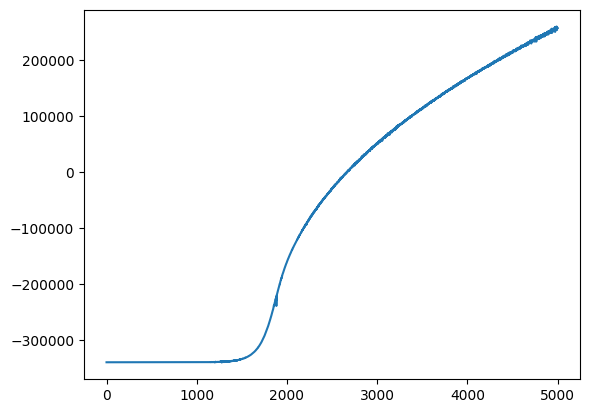

In [6]:
import matplotlib.pyplot as plt

plt.plot(ELBO_list)

In [7]:
# 利用编码器将原始样本 X 压缩为隐状态 z
mu_q, lnsigma_q = vae.Encoder(X)
mu_q

array([[-30.89741996, -78.51043736,  -1.22460127,  22.21522381,
          9.50584221]])

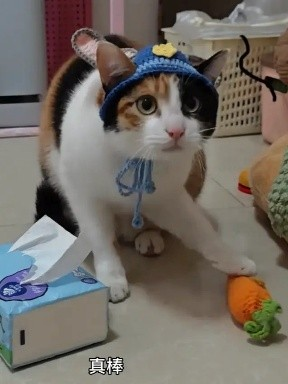

In [8]:
import torch
# 利用解码器将隐状态 z 还原为图片
mu_d, lnsigma_d = vae.Decoder(mu_q)
# 利用生成的均值向量 mu_d 还原成和原始图片具有相同通道数和形状的图片
mu_d = mu_d.reshape(pic.shape)
transforms.ToPILImage()(torch.tensor(mu_d))

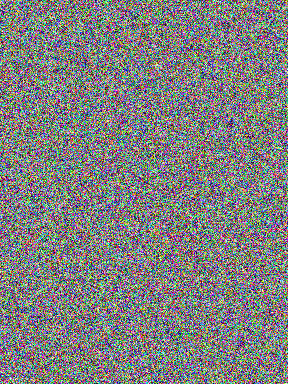

In [9]:
# 利用随机向量干扰原始图像 X
e = cp.random.normal(0, 1, X.shape)
X_ = X + e
transforms.ToPILImage()(torch.tensor(X_.reshape(pic.shape)))

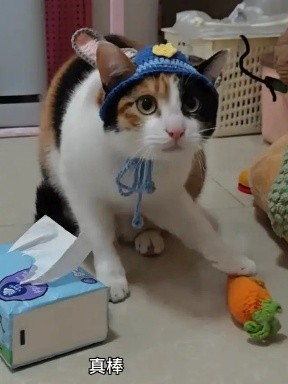

In [10]:
# 将被干扰的原始图像 X 还原
(mu_d, lnsigma_d), (mu_q, lnsigma_q), (e, z) = vae.forward(X_)
# 还原图片原始通道数和形状
mu_d = mu_d.reshape(pic.shape)

transforms.ToPILImage()(torch.tensor(mu_d))

In [11]:
import pandas as pd
from joblib import Parallel, delayed

def zscore(
        x: pd.DataFrame = None
) -> pd.DataFrame:
    
    """
    数据标准化

    Parameters
    ----------
    x : 特征数据集

    Returns
    -------
    x : 标准化后的数据
    """
    
    x = (x - x.mean(axis = 0)) / (x.std(axis = 0, ddof = 1) + 1e-5)
    return x

data = pd.read_csv("./data.csv") # 读取数据，该数据为 ETF 因子数据和收益率数据，总共包含了 60 个因子
data.set_index(["code", "date"], inplace = True)
data.dropna(inplace = True)
ret = data.iloc[:, -1]

groups = data.groupby("date")
data = Parallel(n_jobs = -1)(delayed(zscore)(group) for _, group in groups)
data: pd.DataFrame = pd.concat(data) # 将数据进行标准化

data.head()

,,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X52,X53,X54,X55,X56,X57,X58,X59,X60,daily_return
code,date,,,,,,,,,,,,,,,,,,,,,
159901,2019-05-21,-0.330868,-0.481395,0.127173,-0.489845,-0.118111,0.472330,0.737346,-0.221051,-0.190697,-0.147275,...,1.165477,-0.340923,-0.135495,0.807157,-0.157366,0.854489,-0.468541,0.366543,0.897704,-0.609663
159902,2019-05-21,0.716156,-0.475265,0.135114,1.253833,0.050968,-0.831799,-0.853970,-0.199446,-0.816164,0.134188,...,1.476385,0.276245,-0.225999,0.609536,-0.151618,-1.356035,0.115451,0.364795,1.102657,0.020073
159903,2019-05-21,-0.330861,-0.229014,0.028869,1.273662,0.051436,-1.547630,-0.112495,-0.120574,-0.592831,0.729541,...,-0.030202,-0.524511,-0.322424,0.758846,-0.156681,-1.245205,0.138810,0.302504,0.026754,-0.637914
159905,2019-05-21,-0.330869,-0.432645,0.130955,0.860817,-0.297916,0.951669,0.702815,-0.187485,0.351771,0.033329,...,0.471185,0.467503,-0.299564,1.426364,0.012204,0.748612,-0.118146,0.360152,0.417223,-0.740212
159906,2019-05-21,-2.291000,0.797348,0.141602,-1.396982,0.863223,0.236669,-0.565402,0.226857,-1.035499,0.294321,...,-0.861170,-0.599862,-0.335214,0.497278,-0.155875,-0.784688,-0.445181,-0.388815,-0.579931,-0.522049


In [12]:
start_date = "2020-01-01"
split_date = "2023-01-01"
end_date = "2024-12-29"
data_index = data.reset_index(level = 0).index
train_data = data[(data_index >= start_date) & (data_index < split_date)]
valid_data = data[(data_index >= split_date) & (data_index < end_date)]

X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1][X_train.index]
X_valid = valid_data.iloc[:, :-1]
y_valid = valid_data.iloc[:, -1][X_valid.index] # 拆分训练集和验证集

X_train.head()

,,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60
code,date,,,,,,,,,,,,,,,,,,,,,
159901,2020-01-02,-0.299198,-0.276981,0.055952,1.311973,-0.423774,-0.455034,0.469523,0.273358,0.115936,-0.218295,...,-0.405065,-0.069256,-0.294745,-0.216171,0.825148,0.016485,-0.375643,3.021493,0.281192,-0.075016
159902,2020-01-02,-0.562343,-0.273624,0.087458,1.425880,-0.424275,0.862724,0.195176,0.253734,0.630235,-0.486030,...,0.308186,0.441891,0.296749,-0.304342,0.833904,-0.017146,0.747776,1.935758,0.278314,0.244128
159903,2020-01-02,-0.398985,-0.240101,0.175107,1.023173,0.374470,0.665708,-0.391312,0.215136,0.533928,-0.375829,...,-1.233267,0.160135,-0.620056,-0.118517,0.732737,0.016500,0.278278,-0.166776,0.233145,0.087870
159905,2020-01-02,0.833472,-0.277199,-0.230802,1.215696,-0.313815,-0.504548,1.206767,0.273248,0.013223,-0.147868,...,-0.562423,0.262401,0.689919,0.078861,0.700753,0.039421,-1.413626,0.453644,0.281733,0.015499
159906,2020-01-02,0.098141,-0.002463,0.182682,-0.467602,1.538667,0.823149,-1.190024,-0.343374,0.434082,-0.286009,...,1.692571,-0.322635,-0.668024,-0.256919,0.546698,0.016454,0.674696,-0.304647,0.178287,-0.063783


In [13]:
X_train = cp.array(X_train.values)
X_train

array([[-0.29919846, -0.27698092,  0.05595186, ...,  3.02149277,
         0.28119163, -0.07501565],
       [-0.56234275, -0.27362421,  0.08745833, ...,  1.935758  ,
         0.27831363,  0.24412767],
       [-0.3989855 , -0.24010131,  0.17510675, ..., -0.16677602,
         0.23314537,  0.08787047],
       ...,
       [-0.81308314, -0.2077601 ,  1.27003323, ...,  0.28389176,
         0.16717825, -0.18485916],
       [-0.81308331, -0.19943181,  0.15373509, ...,  0.12937616,
         0.16349099, -0.33958869],
       [-0.81308282, -0.20769537,  0.19119678, ...,  0.09074726,
         0.16714546, -0.18485916]], shape=(251817, 60))

In [14]:
icput_size = 60
hidden_size = 30

# 初始化 VAE 算法
vae = VAE(icput_size = icput_size, hidden_size = hidden_size)

ELBO_list = []

# 优化迭代 500 次

for i in range(500):

    vae.backward(X_train, lr = 1e-2)

    (mu_d, lnsigma_d), (mu_q, lnsigma_q), (e, z) = vae.forward(X_train)
    sigma_q = cp.exp(lnsigma_q)
    sigma_d = cp.exp(lnsigma_d)

    # 计算 KL 散度
    KL = cp.mean(1 / 2 * cp.sum(sigma_q + mu_q ** 2 - lnsigma_q - 1, axis = -1), axis = 0)
    lnE = - icput_size / 2 * cp.log(2 * cp.pi) - 1 / 2 * cp.sum(lnsigma_d, axis = -1) - 1 / 2 * cp.sum((X_train - mu_d) ** 2 / sigma_d, axis = -1)
    lnE = cp.mean(lnE, axis = 0)

    ELBO = lnE - KL
    print(ELBO)

    ELBO_list.append(ELBO.item())

-84.77912668041654
-84.77809664746523
-84.77804033334021
-84.77861307231952
-84.77975609490026
-84.7814578515359
-84.78406403011269
-84.78776699904705
-84.79188526672901
-84.79683239849777
-84.80227279966986
-84.808321627319
-84.81528456451976
-84.82283206862348
-84.83121164931902
-84.84002171357818
-84.84918825200953
-84.85954667334956
-84.8700265258624
-84.88201300429003
-84.89398507324884
-84.90644758976526
-84.91975029649285
-84.93342159418744
-84.94792313886771
-84.96285591786946
-84.97867545591252
-84.99408501579161
-85.01134759360153
-85.02835182900591
-85.04608463548614
-85.0645665546476
-85.08274654687507
-85.10262755140478
-85.12194443716815
-85.14248244494819
-85.1631293391775
-85.1847601376722
-85.20574914649703
-85.22848187941682
-85.25141241824177
-85.27393174677272
-85.29808611377054
-85.32177080426747
-85.34562314475825
-85.37033803342456
-85.39564544954075
-85.42145485535079
-85.44809431815894
-85.47398172284068
-85.50015824993955
-85.52704849555523
-85.55558686652125


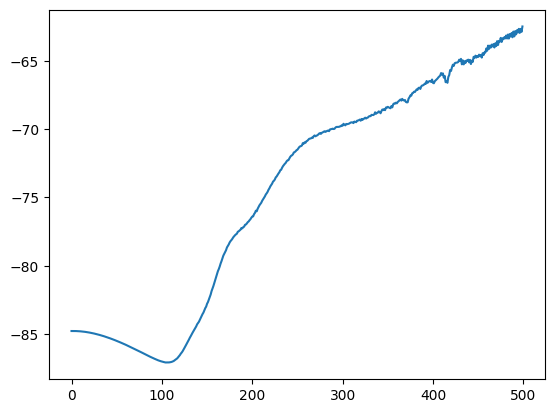

In [15]:
plt.plot(ELBO_list)

In [16]:
# 利用 VAE 的编码器获取降维后生成的隐因子
latent_factor, _ = vae.Encoder(cp.array(data.iloc[:, :-1].values))
latent_factor = latent_factor.get()

latent_factor = pd.DataFrame(latent_factor, index = data.index, columns = [f"X{i}" for i in range(1, hidden_size + 1)])
latent_factor.head()

,,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30
code,date,,,,,,,,,,,,,,,,,,,,,
159901,2019-05-21,-0.449391,0.047794,0.364960,0.082381,1.149792,0.263824,-0.078464,0.309345,0.067427,0.012171,...,0.017795,-0.296404,0.035984,0.335779,-0.327586,1.201375,0.102752,-0.313978,-0.316969,-0.253382
159902,2019-05-21,0.473296,0.109527,0.992741,0.175752,0.818269,0.204825,-0.013540,0.198181,0.065315,0.037327,...,-0.005130,-0.163694,0.085646,0.521198,0.295826,1.028293,-0.009172,0.109701,-0.172677,-0.210483
159903,2019-05-21,0.416692,0.323295,0.342254,0.310740,0.706938,-0.183147,0.301104,-0.263453,0.072903,0.095416,...,-0.039044,-0.007819,0.121197,-0.156105,0.391308,-0.497932,-0.054567,0.387375,1.588056,0.212738
159905,2019-05-21,-1.155601,-0.088089,-0.461214,-0.079800,0.560609,-0.473607,-0.157582,0.069241,-0.096462,-0.072963,...,-0.105477,-0.011385,-0.053189,-0.169125,-0.458811,0.406965,0.120234,-0.271255,-0.081317,0.049060
159906,2019-05-21,-1.358872,-0.104308,0.298456,-0.176109,-2.578421,-0.454288,-0.253891,-0.244365,-0.231027,-0.235717,...,-0.245099,0.374998,-0.202381,-0.139163,0.399066,0.803422,-0.087917,0.498658,1.892945,0.130750


In [17]:
# 计算相关系数矩阵
groups = latent_factor.groupby("date")

num = 0
corr = 0
for _, group in groups:
    num += 1
    corr += group.corr()
corr /= num

corr

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30
X1,1.000000,0.114113,0.483916,0.367226,-0.002154,0.248209,0.163749,-0.073400,0.191954,-0.049565,...,0.033686,-0.037055,0.522096,0.444085,0.090843,0.109543,-0.405007,0.353643,-0.122018,-0.137291
X2,0.114113,1.000000,0.118153,0.609712,0.063722,0.745566,0.329512,0.379845,0.720674,0.644981,...,-0.343983,-0.445640,0.123158,-0.354602,0.037868,-0.094175,0.513375,-0.443259,0.415778,-0.093721
X3,0.483916,0.118153,1.000000,-0.014834,0.001689,0.042394,-0.357271,0.092620,-0.141814,-0.026562,...,-0.370523,0.296224,-0.025004,0.254955,0.582931,0.614849,-0.440129,0.531374,0.172997,-0.553772
X4,0.367226,0.609712,-0.014834,1.000000,0.007390,0.636116,0.662742,0.260713,0.781262,0.101296,...,0.247714,-0.852673,0.786071,0.405699,-0.573395,-0.075378,0.201739,-0.291068,0.083502,-0.090514
X5,-0.002154,0.063722,0.001689,0.007390,1.000000,-0.355954,-0.025033,0.019112,0.003680,0.073297,...,-0.074683,0.026834,-0.017697,-0.072010,0.029308,0.039842,0.050700,-0.021414,-0.019362,0.024650
X6,0.248209,0.745566,0.042394,0.636116,-0.355954,1.000000,0.352581,0.600564,0.777116,0.499033,...,-0.068331,-0.646757,0.307946,-0.041923,-0.210466,-0.058975,0.527777,-0.584637,0.016089,-0.364950
X7,0.163749,0.329512,-0.357271,0.662742,-0.025033,0.352581,1.000000,-0.160280,0.785363,0.254840,...,0.722476,-0.671371,0.415524,0.162378,-0.440003,-0.673426,0.095954,-0.175049,0.070680,0.363608
X8,-0.073400,0.379845,0.092620,0.260713,0.019112,0.600564,-0.160280,1.000000,0.341388,0.429391,...,-0.235692,-0.458559,-0.002156,-0.058055,-0.109950,0.250941,0.700466,-0.722875,-0.347668,-0.715135
X9,0.191954,0.720674,-0.141814,0.781262,0.003680,0.777116,0.785363,0.341388,1.000000,0.522754,...,0.345893,-0.818829,0.385281,0.033165,-0.357058,-0.382489,0.429330,-0.507518,0.053722,-0.095146
X10,-0.049565,0.644981,-0.026562,0.101296,0.073297,0.499033,0.254840,0.429391,0.522754,1.000000,...,-0.154943,-0.136269,-0.441110,-0.669493,0.385061,-0.466904,0.626315,-0.506902,0.047704,-0.011801


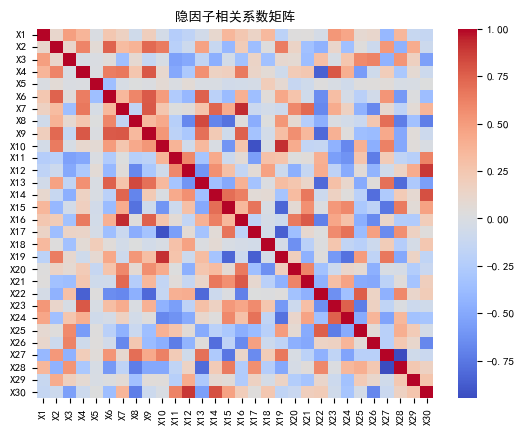

In [18]:
import seaborn as sns

plt.rc("axes", unicode_minus = False)
font = {
    "family": "SimHei",
    "weight": "bold",
    "size": "8"
}
plt.rc("font", **font)

sns.heatmap(corr, annot = False, cmap = "coolwarm")
plt.title("隐因子相关系数矩阵")
plt.show()

In [19]:
# 合并收益率序列

latent_factor = pd.concat([latent_factor, data["daily_return"]], axis = 1)
latent_factor.head()

,,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X22,X23,X24,X25,X26,X27,X28,X29,X30,daily_return
code,date,,,,,,,,,,,,,,,,,,,,,
159901,2019-05-21,-0.449391,0.047794,0.364960,0.082381,1.149792,0.263824,-0.078464,0.309345,0.067427,0.012171,...,-0.296404,0.035984,0.335779,-0.327586,1.201375,0.102752,-0.313978,-0.316969,-0.253382,-0.609663
159902,2019-05-21,0.473296,0.109527,0.992741,0.175752,0.818269,0.204825,-0.013540,0.198181,0.065315,0.037327,...,-0.163694,0.085646,0.521198,0.295826,1.028293,-0.009172,0.109701,-0.172677,-0.210483,0.020073
159903,2019-05-21,0.416692,0.323295,0.342254,0.310740,0.706938,-0.183147,0.301104,-0.263453,0.072903,0.095416,...,-0.007819,0.121197,-0.156105,0.391308,-0.497932,-0.054567,0.387375,1.588056,0.212738,-0.637914
159905,2019-05-21,-1.155601,-0.088089,-0.461214,-0.079800,0.560609,-0.473607,-0.157582,0.069241,-0.096462,-0.072963,...,-0.011385,-0.053189,-0.169125,-0.458811,0.406965,0.120234,-0.271255,-0.081317,0.049060,-0.740212
159906,2019-05-21,-1.358872,-0.104308,0.298456,-0.176109,-2.578421,-0.454288,-0.253891,-0.244365,-0.231027,-0.235717,...,0.374998,-0.202381,-0.139163,0.399066,0.803422,-0.087917,0.498658,1.892945,0.130750,-0.522049


In [20]:
# 拆分训练集和验证集

start_date = "2020-01-01"
split_date = "2024-01-01"
end_date = "2024-12-29"
date_index = latent_factor.reset_index(level = 0).index
train_data = latent_factor[(date_index >= start_date) & (date_index < split_date)]
valid_data = latent_factor[(date_index >= split_date) & (date_index < end_date)]

X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1][X_train.index]
X_valid = valid_data.iloc[:, :-1]
y_valid = valid_data.iloc[:, -1][X_valid.index]

In [21]:
import cupy as cp

class Linear_Regression:

    """
    线性回归算法
    """

    def __init__(self):
        pass

    def fit(self, X: cp.ndarray = None, y: cp.ndarray = None):

        """
        拟合训练数据

        Parameters
        ----------
        X : 特征集
        y : 标签集
        """

        # 在特征集中添加全为 1 的向量，对应线性回归算法的截距项
        X = cp.hstack([cp.ones(len(X)).reshape(-1, 1), X])
        y = y.reshape(-1, 1)

        # 求解算法参数
        self.b = (cp.linalg.inv(X.T @ X) @ X.T @ y).squeeze(1)

    def predict(self, X: cp.ndarray = None) -> cp.ndarray:

        """
        预测标签

        Parameters
        ----------
        X : 特征集

        Returns
        -------
        y_hat : 预测标签
        """

        X = cp.hstack([cp.ones(len(X)).reshape(-1, 1), X])
        y_hat = X @ self.b.reshape(-1, 1)

        return y_hat.squeeze(1)

In [22]:
# 拟合训练样本
lr = Linear_Regression()
lr.fit(cp.array(X_train.values), cp.array(y_train.values))
lr.b

array([ 5.22832457e-03, -6.63717666e-01,  5.57607043e+00,  1.19703448e+00,
       -2.94782630e+00, -2.10570127e-02,  1.39058413e-01,  1.30294891e+00,
        2.53200411e+00,  1.07789056e+00, -2.61896720e+00,  2.70289471e+00,
       -2.26665767e-01, -5.11587827e+00,  5.02890066e-01, -4.61940162e+00,
       -3.63039560e-01,  1.15551252e+00,  2.65968229e-02, -3.19764777e+00,
       -9.73811225e-01,  4.57800730e+00,  9.63275734e-01,  3.35246967e+00,
       -4.13587494e-01,  4.11482668e-01, -7.52411738e-01,  6.56072994e+00,
        1.49615916e+00, -2.07779834e-01, -4.98756260e+00])

In [23]:
# 预测标签
pred = lr.predict(cp.array(latent_factor.iloc[:, :-1].values)).get()
pred = pd.Series(pred, index = latent_factor.index)
pred.head()

code    date      
159901  2019-05-21   -0.063893
159902  2019-05-21   -0.041033
159903  2019-05-21    0.004075
159905  2019-05-21   -0.033266
159906  2019-05-21    0.040866
dtype: float64

In [24]:
# 计算预测值的 IC 表现
ic = pred.unstack().corrwith(ret.unstack())
ic.head()

date
2019-05-21    0.228365
2019-05-22    0.330608
2019-05-23   -0.125368
2019-05-24    0.038331
2019-05-27    0.118946
dtype: float64

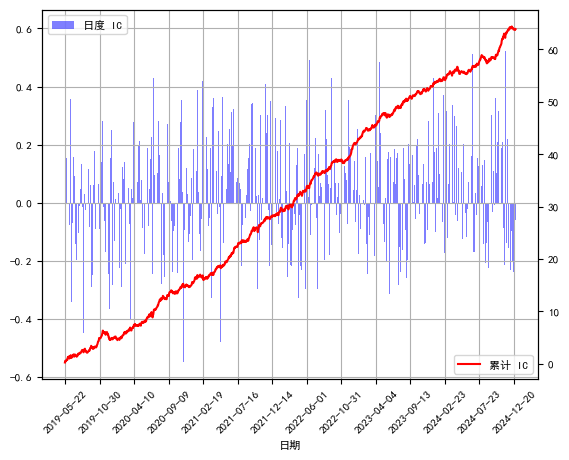

In [25]:
plt.rc("axes", unicode_minus = False)
font = {
    "family": "SimHei",
    "weight": "bold",
    "size": "8"
}
plt.rc("font", **font)

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

# 绘制日度 IC 柱状图
plt.xticks(range(1, len(ic) + 1, 100), rotation = 45)
ax1.bar(ic.index, ic, color = "b", alpha = 0.5, label = "日度 IC")
ax1.grid()
ax1.set_xlabel("日期")
ax1.legend(loc = 2)
# 创建第二个y轴，绘制累计 IC 折线图
cum_ic = ic.cumsum()
ax2 = ax1.twinx()
ax2.plot(cum_ic.index, cum_ic, "-", color = "r", label = "累计 IC")
ax2.legend(loc = 4)

In [26]:
def grouping(
        data: pd.Series = None, 
        group_num: int = 5,
) -> pd.Series:
    
    """
    分组函数

    Parameters
    ----------
    data : 原始数据
    group_num : 分组数

    Returns
    -------
    分组结果
    """

    return pd.qcut(data, group_num, labels = False, duplicates = "drop")

In [27]:
# 将全部 ETF 按照因子表现分 10 组
group_num = 10
groups = pred.groupby("date")
asset_groups = Parallel(n_jobs = -1)(delayed(grouping)(group, group_num) for _, group in groups)
asset_groups = pd.concat(asset_groups)
asset_groups.name = "group"

# 计算分组收益
group_rets = pd.concat([ret, asset_groups], axis = 1)
group_rets = group_rets.groupby(["date", "group"]).mean().unstack()
group_rets.columns = [f"group_{i}" for i in range(group_num)]
group_rets.head()

,group_0,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9
date,,,,,,,,,,
2019-05-21,-0.005040,-0.004221,-0.010112,-0.009469,-0.004819,-0.008820,-0.007298,-0.004642,-0.004589,0.003597
2019-05-22,-0.018516,-0.012594,-0.013980,-0.008783,-0.012265,-0.011566,-0.010222,-0.011230,-0.006591,-0.007029
2019-05-23,-0.003589,-0.002690,0.001099,-0.001774,0.000339,-0.001480,-0.003715,-0.005267,-0.001200,-0.010448
2019-05-24,0.013328,0.012171,0.013028,0.012137,0.013672,0.017038,0.018340,0.019216,0.012960,0.013021
2019-05-27,-0.001352,-0.003810,0.001846,-0.000738,0.003951,0.000569,-0.000116,0.001543,-0.001033,0.000486


In [28]:
# 分组平均收益
mean = group_rets.mean(axis = 0)
mean

group_0   -0.000791
group_1    0.000040
group_2    0.000117
group_3    0.000111
group_4    0.000255
group_5    0.000287
group_6    0.000371
group_7    0.000535
group_8    0.000604
group_9    0.000902
dtype: float64

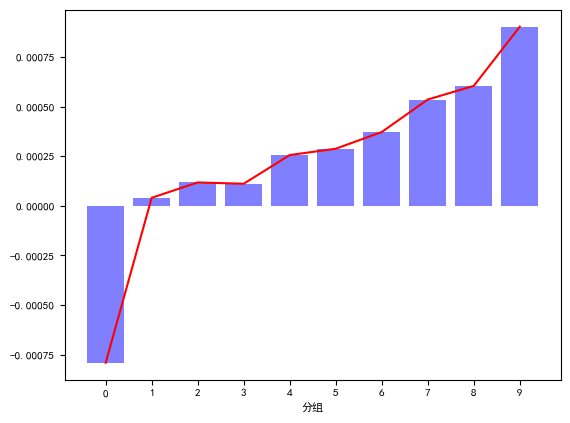

In [29]:
plt.rc("axes", unicode_minus = False)
font = {
    "family": "SimHei",
    "weight": "bold",
    "size": "8"
}
plt.rc("font", **font)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 绘制日度分组平均收益
plt.xticks(range(group_num))
ax.bar(range(group_num), mean, color = "b", alpha = 0.5)
ax.set_xlabel("分组")
# 绘制日度分组均值收益折线图
ax.plot(range(group_num), mean, "-", color = "r")

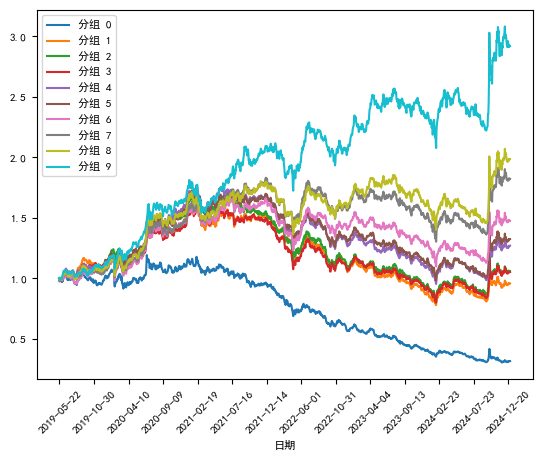

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 绘制日度分组累计收益折线图
plt.xticks(range(1, len(group_rets.iloc[:]) + 1, 100), rotation = 45)
ax.plot((1 + group_rets.iloc[:]).cumprod(), label = [f"分组 {i}" for i in range(group_num)])
ax.set_xlabel("日期")
ax.legend()